# <span style="color:darkblue">03-Spot_decomposition</span>

In this notebook we will guide you through performing spot decomposition using the BigFISH libray, opening your images in Napari, and saving the generated decomposed spot detection data. We decompose Transcription sites (Txs) within the cell nucleus to estimate the number of nascent mRNAs. For more documentation of the BigFISH library see: https://big-fish.readthedocs.io/en/stable/index.html. At the bottom of this notebook batch decomposition can be performed.

## 3.0 - Load libraries

In [11]:
import re
from glob import glob
from skimage import io
from pathlib import Path
import numpy as np
import napari
import matplotlib.pyplot as plt
from bigfish.detection import decompose_dense
from bigfish.stack import remove_background_gaussian

import sys
sys.path.append('../')
from src.misc import group_experiments_sd, load_data

***

## 3.1 - Example of spot decomposition on a single image

In [12]:
#choose FISH channel
channel='CY35'
Strain= 'CET111'
mRNA='HWP1CAL610CLB2Q670'
condition='SPIDER37'
Fov='02'
# load image data
RNAs = io.imread(f'../data/restructured_data/replicate1/{Strain}_{mRNA}_{condition}_{channel}_{Fov}.tif')
DAPI = io.imread(f'../data/restructured_data/replicate1//{Strain}_{mRNA}_{condition}_DAPI_{Fov}.tif')
DIC = io.imread(f'../data/restructured_data/replicate1//{Strain}_{mRNA}_{condition}_DIC_{Fov}.tif')
mask = io.imread(f'../data/restructured_data/replicate1//Masks/{Strain}_{mRNA}_{condition}_DIC_{Fov}_seg.tif')
nuclear_mask = io.imread(f'../data/restructured_data/replicate1/Masks/{Strain}_{mRNA}_{condition}_DAPI_{Fov}_seg.tif')

# load spot data
spot_data = np.load(glob(f'../data/restructured_data/replicate1/Spots/{Strain}_{mRNA}_{condition}_{channel}_{Fov}_spots_thr*.npy')[0])
print(f'loaded : {len(spot_data)}')

loaded : 396


Add the loaded data to a Napari viewer and inspect whether the data is loaded correctly.

In [13]:
viewer=napari.Viewer()

#scale
scale = (200,65,65)

viewer.add_image(RNAs, name='RNA channel',scale=scale)
viewer.add_image(DAPI, name='DAPI channel',scale=scale)

# parameter for guassian filtering
sigma = (0.75,2.3,2.3)
# guassian filtering
filt_RNAs=remove_background_gaussian(RNAs, sigma=sigma)

viewer.add_image(filt_RNAs, name='filt RNA channel',scale=scale)
viewer.add_labels(nuclear_mask, name='nuclei',scale=scale[-2:])
viewer.add_points(spot_data,scale=scale)

<Points layer 'spot_data' at 0x20890e840d0>

Decompose dense regions into seperate spots.

In [14]:
# parameters
spot_radius = (1250, 170, 170)

In [15]:
spots, dense_regions, reference_spots = decompose_dense(
    viewer.layers['filt RNA channel'].data,
    spot_data,
    voxel_size=scale,
    spot_radius=spot_radius,
    alpha=0.5,beta=2,gamma=1
)

Inspect whether the reference spot looks approximately gaussian.

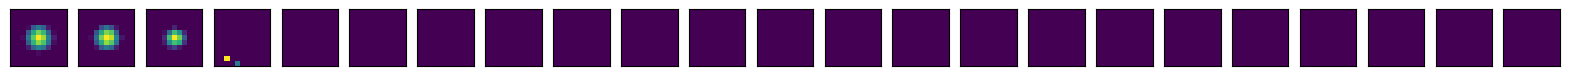

In [16]:
fig,axis=plt.subplots(ncols=reference_spots.shape[0],figsize=(20,10))

for i,ax in zip(range(len(axis)),axis):
    ax.imshow(reference_spots[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Inspect the detected dense RNA regions in Napari. Make sure all TXs in the nuclei are correctly identified. 

Note: false Txs identified outside of the cell nucleus will be filtered out in the next notebook.

In [17]:
viewer.add_points(
    dense_regions[:,:3],
    scale=scale,
    edge_color='blue',
    name='Txs'
)


<Points layer 'Txs' at 0x2088fb9a800>

Number of Nascent RNAs per potential Txs.

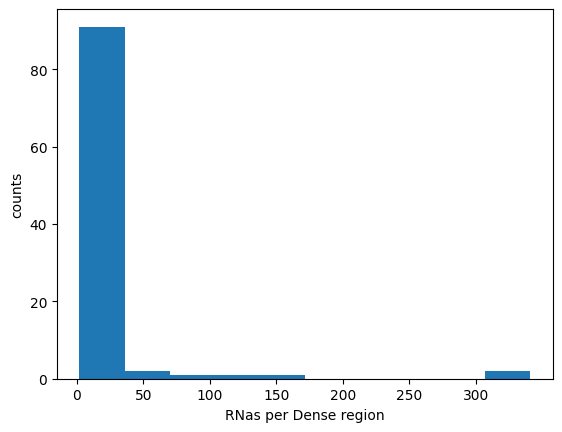

In [18]:
fig, ax = plt.subplots(facecolor='white')
ax.hist(dense_regions[:, 3])
ax.set_xlabel('RNas per Dense region')
ax.set_ylabel('counts')
ax.set_xticks(range(0, max(dense_regions[:, 3] + 1), 50));

***

## 3.2 - Batch decomposition

In [19]:
# paths
root_dir = '../Data/restructured_data/replicate1'

#choose FISH channel
channel='CY35'

#parameters - adjust if necessary
scale = (200, 65, 65)
spot_radius = (1250, 170, 170)
sigma=(0.75, 2.3, 2.3)
patch_size = (200, 200)

In [20]:
experiments = group_experiments_sd(root_dir,channel)

print('I found the following experiments:')
print(experiments.keys())
print('select applicable experiments')

I found the following experiments:
dict_keys(['CET111_HWP1CAL610CLB2Q670_SPIDER37', 'CET111_HWP1CAL610CLB2Q670_TSB30', 'CET111_HWP1CAL610CLB2Q670_TSB37'])
select applicable experiments


In [21]:
channel='CY35'
experiments_to_process = ['CET111_HWP1CAL610CLB2Q670_SPIDER37']

for identifier in experiments_to_process:
    replicates = experiments[identifier]
    
    for replicate, paths, in replicates.items():
        print(f'processing {identifier=}, {replicate=}')
        data = load_data(paths)
        spot_file_name = Path(paths['spots']).stem
        save_path = Path(root_dir,'Spots decomposition',spot_file_name)
        
        process = True
        # check if all files required for this step have been loaded
        for entry in ['spots', channel]:
            if data.get(entry) is None:
                print(f'{identifier=}, {replicate=}, {entry=} could not be found')
                print(f'skipping {identifier=}, {replicate=}!')
                process=False
        
        if process:
            RNAs = data.get(channel)            
            spot_data = data.get('spots')
            
            RNAs_filt=remove_background_gaussian(RNAs, sigma=sigma)
            
            spots, dense_regions, reference_spots = decompose_dense(
                RNAs_filt,
                spot_data,
                voxel_size=scale,
                spot_radius=spot_radius,
                alpha=0.5,beta=2,gamma=1
            )
            
            np.save(fr"{save_path}.npy", spots)
            np.save(Path(save_path.parents[0],f"{save_path.name}_dd_regions.npy"), dense_regions)
            io.imsave(Path(save_path.parents[0],f"{save_path.name}_rf_spot.tif"), reference_spots)
            
            print('done')
            
        print(10*'-')

processing identifier='CET111_HWP1CAL610CLB2Q670_SPIDER37', replicate=2
done
----------


C:\Users\asus5\AppData\Local\Temp\ipykernel_22256\3241948582.py:37: UserWarning: D:\smFISH-analysis-main2WTHWP1CLB2\Data\restructured_data\replicate1\Spots decomposition\CET111_HWP1CAL610CLB2Q670_SPIDER37_CY35_02_spots_thr8_rf_spot.tif is a low contrast image
  io.imsave(Path(save_path.parents[0],f"{save_path.name}_rf_spot.tif"), reference_spots)
